# Seismic Wave Tomography via Fast Marching - Demo on switching regularization and L-curve

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we would like to demonstrate the capability of CoFI to easily
switch between different types of regularizations.

We will use `cofi` to run a seismic wave tomography example, in which
the forward calculation is based on the Fast Marching Fortran code by Nick
Rawlinson. The Fast Marching code is wrapped in package `espresso`.

We refer you to [fmm_tomography.ipynb](./fmm_tomography.ipynb) for further theretical
details.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
import espresso

### Understanding the inference problem

Before we starting working with `cofi`, let's get familiar with the problem itself.

Below is a plot of the true model and the paths generated from this model. As you can see,
there are two anomalies, one with lower velocity (red, top left) and the other with higher
velocity (blue, bottom right).

 New data set has:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.008911182496368759 0.0153757024856463 
 Mean travel time: 0.01085811731230709


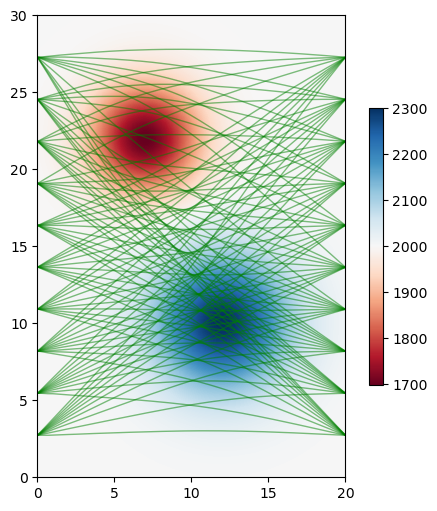

In [3]:
fmm = espresso.FmmTomography()

fmm.plot_model(fmm.good_model, with_paths=True);

In [4]:
pprint.pprint(fmm.metadata)

{'author_names': ['Nick Rawlinson', 'Malcolm Sambridge'],
 'citations': [('Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic '
                'wavefront tracking in 3-D heterogeneous media: applications '
                'with multiple data classes, Explor. Geophys., 37, 322-330.',
                ''),
               ('Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of '
                'active and passive source datasets for 3-D seismic structure '
                'with application to Tasmania, Geophys. Res. Lett., 33 L24313',
                '10.1029/2006GL028105'),
               ('de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A '
                'practical grid based method for tracking multiple refraction '
                'and reflection phases in 3D heterogeneous media, Geophys. J. '
                'Int., 167, 253-270',
                '')],
 'contact_email': 'Malcolm.Sambridge@anu.edu.au',
 'contact_name': 'Malcolm Sambridge',
 'linked_sites': [('Soft

## 1. Problem setup and utilities

In [5]:
# get problem information from  espresso FmmTomography
model_size = fmm.model_size         # number of model parameters
model_shape = fmm.model_shape       # 2D spatial grids
data_size = fmm.data_size           # number of data points
ref_start_slowness = fmm.starting_model

In [6]:
def objective_func(slowness, reg):
    ttimes = fmm.forward(slowness)
    residual = fmm.data - ttimes
    data_misfit = residual.T @ residual
    model_reg = reg(slowness)
    return data_misfit + model_reg

def gradient(slowness, reg):
    ttimes, A = fmm.forward(slowness, with_jacobian=True)
    data_misfit_grad = -2 * A.T @ (fmm.data - ttimes)
    model_reg_grad = reg.gradient(slowness)
    return data_misfit_grad + model_reg_grad

def hessian(slowness, reg):
    A = fmm.jacobian(slowness)
    data_misfit_hess = 2 * A.T @ A
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

## 2. Invert with quadratic smoothing and damping regularization terms

### 2.1 Define BaseProblem

In [7]:
# define CoFI BaseProblem
fmm_problem_quadratic_reg = cofi.BaseProblem()
fmm_problem_quadratic_reg.set_initial_model(ref_start_slowness)

In [8]:
# add regularization: flattening + smoothing
smoothing_factor = 2
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)

In [9]:
fmm_problem_quadratic_reg.set_objective(objective_func, args=[reg_smoothing])
fmm_problem_quadratic_reg.set_gradient(gradient, args=[reg_smoothing])
fmm_problem_quadratic_reg.set_hessian(hessian, args=[reg_smoothing])

### 2.2 Define InversionOptions

In [10]:
my_options = cofi.InversionOptions()

my_options.set_tool("cofi.simple_newton")
my_options.set_params(
    num_iterations=20, 
    step_length=1, 
    verbose=True, 
    hessian_is_symmetric=True
)

### 2.3 Start an inversion

In [11]:
inv = cofi.Inversion(fmm_problem_quadratic_reg, my_options)
inv_result_quadratic_reg = inv.run()
inv_result_quadratic_reg.summary()

Iteration #0, updated objective function value: 1.6883079515460515e-07
Iteration #1, updated objective function value: 7.928200334785323e-09
Change in objective function below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.00047876 0.00047801 0.00047748 ... 0.00051017 0.00051025 0.00051022]
num_iterations: 1
objective_val: 7.928200334785323e-09
n_obj_evaluations: 3
n_grad_evaluations: 2
n_hess_evaluations: 2


### 2.4 Plotting

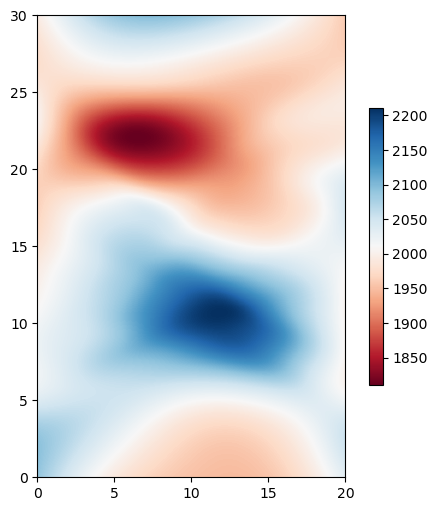

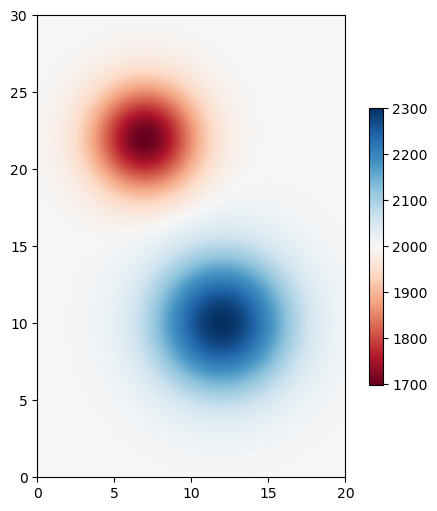

In [12]:
fmm.plot_model(inv_result_quadratic_reg.model);            # inverted model
fmm.plot_model(fmm.good_model);       # true model

---

## 3. Invert with Gaussian prior as regularization term

Instead of using a smoothing and damping regularization, in this section, we
use a model covariance matrix and prior model.

$\chi_{P}^{2}=\left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right)^T C_d^{-1} \left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right) + \left( \mathbf{m} - \mathbf{m}_p \right)^T C_p^{-1} \left( \mathbf{m} - \mathbf{m}_p \right)$

$\Delta \mathbf{m}= ({J}^T {C}_d^{-1} {J}+{C}_p^{-1})^{-1} ({J}^T{C}_d^{-1} (\mathbf{y}-\mathbf{f}(\mathbf{m}))+{C}_p^{-1}(\mathbf{m}_p-\mathbf{m}))$

We can use CoFI's utility module to help us generate a the Gaussian prior term.

### 3.1 Define BaseProblem

In [13]:
# define CoFI BaseProblem
fmm_problem_gaussian_prior = cofi.BaseProblem()
fmm_problem_gaussian_prior.set_initial_model(ref_start_slowness)

In [14]:
# add regularization: Gaussian prior
corrx = 3.0
corry = 3.0
sigma_slowness = 0.5
gaussian_prior = cofi.utils.GaussianPrior(
    model_covariance_inv=((corrx, corry), sigma_slowness),
    mean_model=ref_start_slowness.reshape(model_shape)
)

In [15]:
fmm_problem_gaussian_prior.set_objective(objective_func, args=[gaussian_prior])
fmm_problem_gaussian_prior.set_gradient(gradient, args=[gaussian_prior])
fmm_problem_gaussian_prior.set_hessian(hessian, args=[gaussian_prior])

### 3.2 Start an inversion

In [16]:
# reuse the previously defined InversionOptions object
my_options.set_params(verbose=True)
inv = cofi.Inversion(fmm_problem_gaussian_prior, my_options)
inv_result_gaussian_prior = inv.run()
inv_result_gaussian_prior.summary()

Iteration #0, updated objective function value: 3.633219726912791e-07
Iteration #1, updated objective function value: 2.350718903302728e-07
Change in objective function below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.00049706 0.00049599 0.00049456 ... 0.00050298 0.00050221 0.00050161]
num_iterations: 1
objective_val: 2.350718903302728e-07
n_obj_evaluations: 3
n_grad_evaluations: 2
n_hess_evaluations: 2


### 3.3 Plotting

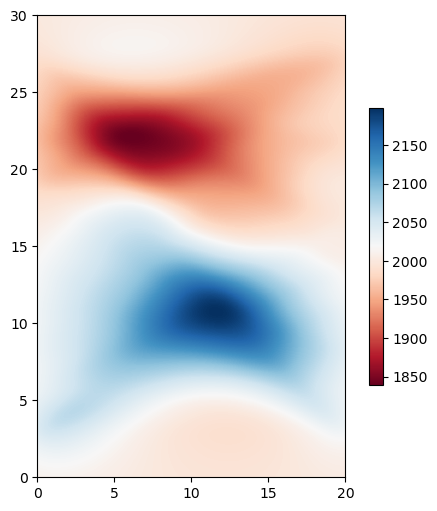

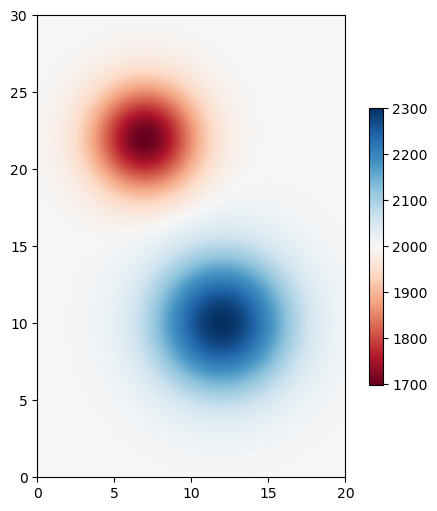

In [17]:
fmm.plot_model(inv_result_gaussian_prior.model);            # gaussian prior
fmm.plot_model(fmm.good_model);       # true model

## 4. L-curve

In [18]:
# regularization parameters to test
lambdas = np.logspace(-8, 8, 25)

# arrays to hold the norms
residual_norms = []
reg_norms = []
model_norms = []

reg_smoothing = cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)

my_options = cofi.InversionOptions()
my_options.set_tool("cofi.simple_newton")
my_options.set_params(
    num_iterations=20, 
    step_length=1, 
    verbose=False, 
    hessian_is_symmetric=True
)

# iterate over the regularization parameters
for lamb in lambdas:
    print(f"running inversion for lambda = {lamb}")
    # solve your inverse problem here
    new_reg = lamb * reg_smoothing
    fmm_problem_quadratic_reg.set_objective(objective_func, args=[new_reg])
    fmm_problem_quadratic_reg.set_gradient(gradient, args=[new_reg])
    fmm_problem_quadratic_reg.set_hessian(hessian, args=[new_reg])
    inv = cofi.Inversion(fmm_problem_quadratic_reg, my_options)
    m = inv.run().model

    # calculate the norms
    res_norm = np.linalg.norm(fmm.forward(m) - fmm.data)
    reg_norm = np.sqrt(reg_smoothing(m))
    model_norm = np.linalg.norm(m)

    # add to the lists
    residual_norms.append(res_norm)
    reg_norms.append(reg_norm)
    model_norms.append(model_norm)
    print(res_norm, reg_norm, model_norm)

running inversion for lambda = 1e-08
4.004801797915097e-05 0.000519826471292757 0.01953174623715881
running inversion for lambda = 4.641588833612782e-08
4.004695118736693e-05 0.0005198253343211194 0.019531746308300353
running inversion for lambda = 2.1544346900318822e-07
4.004827996122604e-05 0.0005198200822743226 0.01953174595422809
running inversion for lambda = 1e-06
4.004767952447823e-05 0.0005197966597008495 0.01953174565425949
running inversion for lambda = 4.641588833612773e-06
4.004636160136788e-05 0.0005196933226184867 0.019531743614406603
running inversion for lambda = 2.1544346900318823e-05
4.0042838223193533e-05 0.0005192047941798086 0.019531734356538974
running inversion for lambda = 0.0001
4.1235256457451034e-05 0.00042006601704406253 0.019529131685326887
running inversion for lambda = 0.00046415888336127724
5.249145024584417e-05 0.00020629113238773141 0.01951941588721299
running inversion for lambda = 0.002154434690031882
5.048806774255279e-05 0.00012032468141320477 0.01

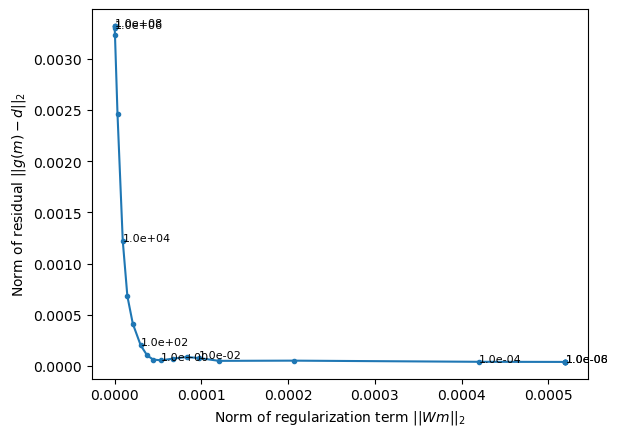

In [19]:
# plot the L-curve
plt.plot(reg_norms, residual_norms, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(0, len(lambdas), 3):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norms[i], residual_norms[i]), fontsize=8)

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [20]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.1
espresso 0.3.8
numpy 1.23.5
matplotlib 3.7.1
